In [1]:
import os
from glob import glob
from time import time
import SimpleITK as sitk
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from monai.handlers.utils import from_engine
from monai.networks.nets import AttentionUnet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    CropForegroundd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import onnxruntime
from tqdm.notebook import tqdm

import torch

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /home/<username>/anaconda3/envs/med/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.0
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For d

In [2]:
def add_channel_dim(data_path: str):
    img = sitk.ReadImage(data_path)
    array = sitk.GetArrayFromImage(img)
    result = np.expand_dims(array, axis=-1)
    return result

In [3]:
DATA_ROOT = 'Data/MICCAI_BraTS2020_TrainingData'
NUMPY_DATA_ROOT = os.path.join('Data', 'BraTS2020_Training_Numpy')
MRI_TYPE = 't1ce'
LABEL_SUFFIX = 'seg'
TEST_RATIO = 0.2
data_paths = sorted(glob(os.path.join(DATA_ROOT, '**', f'*_{MRI_TYPE}.nii.gz'), recursive=True))
label_paths = sorted(glob(os.path.join(DATA_ROOT, '**', f'*_{LABEL_SUFFIX}.nii.gz'), recursive=True))

print(f"Found {len(data_paths)} data and {len(label_paths)} labels")
assert len(data_paths) == len(label_paths), "Number of data and labels do not match"

# np_image_paths = []
# np_label_paths = []
# 
# if not os.path.exists(NUMPY_DATA_ROOT):
#     os.makedirs(NUMPY_DATA_ROOT + os.sep + 'image', exist_ok=True)
#     os.makedirs(NUMPY_DATA_ROOT + os.sep + 'label', exist_ok=True)
#     for image, label in tqdm(zip(data_paths, label_paths)):
#         img_file_name = os.path.basename(image).split('.')[0]+".npy"
#         lbl_file_name = os.path.basename(label).split('.')[0]+".npy"
#         image_path = str(os.path.join(NUMPY_DATA_ROOT, 'image', img_file_name))
#         label_path = str(os.path.join(NUMPY_DATA_ROOT, 'label', lbl_file_name))
#         np_image_paths.append(image_path)
#         np_label_paths.append(label_path)
#         np.save(image_path, add_channel_dim(image))
#         np.save(label_path, add_channel_dim(label))
# else:
#     np_image_paths = glob(os.path.join(NUMPY_DATA_ROOT, 'image', '*.npy'))
#     np_label_paths = glob(os.path.join(NUMPY_DATA_ROOT, 'label', '*.npy'))
#     print("Found {} numpy images and {} numpy labels".format(len(np_image_paths), len(np_label_paths)))
    
# data_dicts = [
#     {"image": image_name, "label": label_name}
#     for image_name, label_name in zip(np_image_paths, np_label_paths)
# ]
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(data_paths, label_paths)
]
train_data, validation_data = train_test_split(data_dicts, test_size=TEST_RATIO, random_state=42)
print("Splitting dataset in the ratio {}".format(TEST_RATIO))
print("Number of training images: {}".format(len(train_data)))
print("Number of validation images: {}".format(len(validation_data)))

Found 369 data and 369 labels
Splitting dataset in the ratio 0.2
Number of training images: 295
Number of validation images: 74


## Define a new transform to convert brain tumor labels
Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [4]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 4 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 1 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            # result = []
            # merge label 2 and label 3 to construct TC
            # whole_tumor = torch.logical_or(d[key] == 2, d[key] == 3)
            # result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            whole_tumor = torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 4), d[key] == 1)
            # label 2 is ET
            # result.append(d[key] == 2)
            d[key] = whole_tumor.float()
        return d

In [5]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        # LoadImaged(keys=["image", "label"], reader='NumpyReader'),
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        # CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=False),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        # LoadImaged(keys=["image", "label"], reader='NumpyReader'),
        LoadImaged(keys=["image", "label"], reader="nibabelreader"),
        EnsureChannelFirstd(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        # CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=False),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [6]:
# here we don't cache any data in case out of memory issue
train_ds = Dataset(data=train_data,transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = Dataset(data=validation_data,transform=val_transform)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

image shape: torch.Size([1, 240, 240, 155])


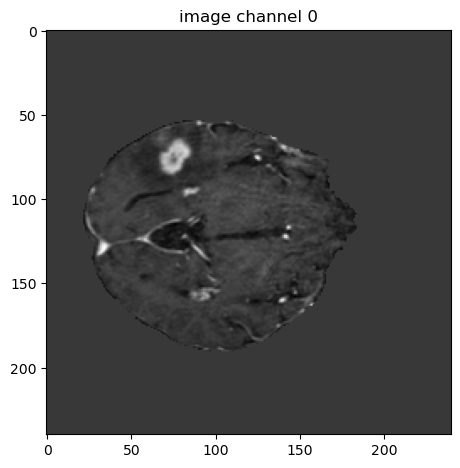

label shape: torch.Size([1, 240, 240, 155])


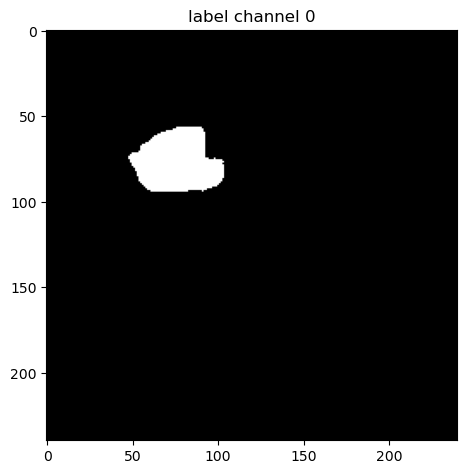

In [7]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[9]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(1):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(1):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu(), cmap='gray')
plt.show()

## Create Model, Loss and Optimizer

In [8]:
max_epochs = 300
val_interval = 2
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = AttentionUnet(spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    dropout=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.amp.autocast(device_type='cuda'):
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

## Train

In [9]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_wt = []

total_start = time()
for epoch in range(max_epochs):
    epoch_start = time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in (pbar:= tqdm(train_loader)):
        step_start = time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        pbar.set_description(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_wt = metric_batch[0].item()
            metric_values_wt.append(metric_wt)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join('Checkpoints', "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" wt: {metric_wt:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time() - epoch_start):.4f}")
total_time = time() - total_start

----------
epoch 1/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 1 average loss: 0.9214
time consuming of epoch 1 is: 131.5714
----------
epoch 2/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 2 average loss: 0.9062
saved new best metric model
current epoch: 2 current mean dice: 0.0904 wt: 0.0904
best mean dice: 0.0904 at epoch: 2
time consuming of epoch 2 is: 144.1007
----------
epoch 3/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 3 average loss: 0.8949
time consuming of epoch 3 is: 123.6968
----------
epoch 4/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 4 average loss: 0.8849
current epoch: 4 current mean dice: 0.0888 wt: 0.0888
best mean dice: 0.0904 at epoch: 2
time consuming of epoch 4 is: 140.9966
----------
epoch 5/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 5 average loss: 0.8735
time consuming of epoch 5 is: 123.6901
----------
epoch 6/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 6 average loss: 0.8616
saved new best metric model
current epoch: 6 current mean dice: 0.0995 wt: 0.0995
best mean dice: 0.0995 at epoch: 6
time consuming of epoch 6 is: 140.5610
----------
epoch 7/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 7 average loss: 0.8462
time consuming of epoch 7 is: 123.8445
----------
epoch 8/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 8 average loss: 0.8276
saved new best metric model
current epoch: 8 current mean dice: 0.1114 wt: 0.1114
best mean dice: 0.1114 at epoch: 8
time consuming of epoch 8 is: 140.8823
----------
epoch 9/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 9 average loss: 0.8028
time consuming of epoch 9 is: 123.9430
----------
epoch 10/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 10 average loss: 0.7374
saved new best metric model
current epoch: 10 current mean dice: 0.6467 wt: 0.6467
best mean dice: 0.6467 at epoch: 10
time consuming of epoch 10 is: 140.8695
----------
epoch 11/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 11 average loss: 0.6725
time consuming of epoch 11 is: 123.5834
----------
epoch 12/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 12 average loss: 0.6104
saved new best metric model
current epoch: 12 current mean dice: 0.6624 wt: 0.6624
best mean dice: 0.6624 at epoch: 12
time consuming of epoch 12 is: 141.1348
----------
epoch 13/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 13 average loss: 0.5435
time consuming of epoch 13 is: 124.4251
----------
epoch 14/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 14 average loss: 0.4867
saved new best metric model
current epoch: 14 current mean dice: 0.7075 wt: 0.7075
best mean dice: 0.7075 at epoch: 14
time consuming of epoch 14 is: 141.1827
----------
epoch 15/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 15 average loss: 0.4354
time consuming of epoch 15 is: 124.3763
----------
epoch 16/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 16 average loss: 0.3931
current epoch: 16 current mean dice: 0.7020 wt: 0.7020
best mean dice: 0.7075 at epoch: 14
time consuming of epoch 16 is: 141.4742
----------
epoch 17/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 17 average loss: 0.3644
time consuming of epoch 17 is: 123.8576
----------
epoch 18/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 18 average loss: 0.3416
saved new best metric model
current epoch: 18 current mean dice: 0.7265 wt: 0.7265
best mean dice: 0.7265 at epoch: 18
time consuming of epoch 18 is: 140.7479
----------
epoch 19/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 19 average loss: 0.3169
time consuming of epoch 19 is: 123.9619
----------
epoch 20/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 20 average loss: 0.2977
saved new best metric model
current epoch: 20 current mean dice: 0.7449 wt: 0.7449
best mean dice: 0.7449 at epoch: 20
time consuming of epoch 20 is: 141.0122
----------
epoch 21/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 21 average loss: 0.2849
time consuming of epoch 21 is: 123.8269
----------
epoch 22/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 22 average loss: 0.2709
current epoch: 22 current mean dice: 0.7282 wt: 0.7282
best mean dice: 0.7449 at epoch: 20
time consuming of epoch 22 is: 141.3296
----------
epoch 23/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 23 average loss: 0.2565
time consuming of epoch 23 is: 124.0764
----------
epoch 24/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 24 average loss: 0.2560
current epoch: 24 current mean dice: 0.7245 wt: 0.7245
best mean dice: 0.7449 at epoch: 20
time consuming of epoch 24 is: 140.7179
----------
epoch 25/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 25 average loss: 0.2534
time consuming of epoch 25 is: 124.1197
----------
epoch 26/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 26 average loss: 0.2382
current epoch: 26 current mean dice: 0.7132 wt: 0.7132
best mean dice: 0.7449 at epoch: 20
time consuming of epoch 26 is: 140.2767
----------
epoch 27/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 27 average loss: 0.2272
time consuming of epoch 27 is: 123.1345
----------
epoch 28/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 28 average loss: 0.2310
saved new best metric model
current epoch: 28 current mean dice: 0.7505 wt: 0.7505
best mean dice: 0.7505 at epoch: 28
time consuming of epoch 28 is: 140.1859
----------
epoch 29/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 29 average loss: 0.2180
time consuming of epoch 29 is: 123.4007
----------
epoch 30/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 30 average loss: 0.2217
saved new best metric model
current epoch: 30 current mean dice: 0.7658 wt: 0.7658
best mean dice: 0.7658 at epoch: 30
time consuming of epoch 30 is: 140.2575
----------
epoch 31/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 31 average loss: 0.2081
time consuming of epoch 31 is: 123.4911
----------
epoch 32/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 32 average loss: 0.2116
current epoch: 32 current mean dice: 0.7530 wt: 0.7530
best mean dice: 0.7658 at epoch: 30
time consuming of epoch 32 is: 140.2990
----------
epoch 33/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 33 average loss: 0.2200
time consuming of epoch 33 is: 123.5006
----------
epoch 34/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 34 average loss: 0.2059
current epoch: 34 current mean dice: 0.7414 wt: 0.7414
best mean dice: 0.7658 at epoch: 30
time consuming of epoch 34 is: 140.1203
----------
epoch 35/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 35 average loss: 0.2086
time consuming of epoch 35 is: 123.8237
----------
epoch 36/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 36 average loss: 0.2061
current epoch: 36 current mean dice: 0.7489 wt: 0.7489
best mean dice: 0.7658 at epoch: 30
time consuming of epoch 36 is: 140.3062
----------
epoch 37/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 37 average loss: 0.2053
time consuming of epoch 37 is: 123.6426
----------
epoch 38/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 38 average loss: 0.2025
current epoch: 38 current mean dice: 0.7094 wt: 0.7094
best mean dice: 0.7658 at epoch: 30
time consuming of epoch 38 is: 140.3306
----------
epoch 39/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 39 average loss: 0.2041
time consuming of epoch 39 is: 123.3972
----------
epoch 40/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 40 average loss: 0.1900
current epoch: 40 current mean dice: 0.7529 wt: 0.7529
best mean dice: 0.7658 at epoch: 30
time consuming of epoch 40 is: 140.2384
----------
epoch 41/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 41 average loss: 0.1900
time consuming of epoch 41 is: 123.6371
----------
epoch 42/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 42 average loss: 0.1855
current epoch: 42 current mean dice: 0.7621 wt: 0.7621
best mean dice: 0.7658 at epoch: 30
time consuming of epoch 42 is: 140.4107
----------
epoch 43/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 43 average loss: 0.2003
time consuming of epoch 43 is: 123.2234
----------
epoch 44/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 44 average loss: 0.2007
current epoch: 44 current mean dice: 0.7446 wt: 0.7446
best mean dice: 0.7658 at epoch: 30
time consuming of epoch 44 is: 140.6053
----------
epoch 45/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 45 average loss: 0.1918
time consuming of epoch 45 is: 123.5340
----------
epoch 46/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 46 average loss: 0.1851
saved new best metric model
current epoch: 46 current mean dice: 0.7719 wt: 0.7719
best mean dice: 0.7719 at epoch: 46
time consuming of epoch 46 is: 140.1976
----------
epoch 47/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 47 average loss: 0.1822
time consuming of epoch 47 is: 123.3678
----------
epoch 48/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 48 average loss: 0.1849
current epoch: 48 current mean dice: 0.7601 wt: 0.7601
best mean dice: 0.7719 at epoch: 46
time consuming of epoch 48 is: 140.0844
----------
epoch 49/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 49 average loss: 0.1805
time consuming of epoch 49 is: 123.3171
----------
epoch 50/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 50 average loss: 0.1856
current epoch: 50 current mean dice: 0.7450 wt: 0.7450
best mean dice: 0.7719 at epoch: 46
time consuming of epoch 50 is: 140.2557
----------
epoch 51/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 51 average loss: 0.1856
time consuming of epoch 51 is: 123.2314
----------
epoch 52/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 52 average loss: 0.1840
current epoch: 52 current mean dice: 0.7706 wt: 0.7706
best mean dice: 0.7719 at epoch: 46
time consuming of epoch 52 is: 140.1780
----------
epoch 53/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 53 average loss: 0.1736
time consuming of epoch 53 is: 123.4687
----------
epoch 54/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 54 average loss: 0.1723
current epoch: 54 current mean dice: 0.7687 wt: 0.7687
best mean dice: 0.7719 at epoch: 46
time consuming of epoch 54 is: 140.2830
----------
epoch 55/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 55 average loss: 0.1767
time consuming of epoch 55 is: 123.4296
----------
epoch 56/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 56 average loss: 0.1735
saved new best metric model
current epoch: 56 current mean dice: 0.7726 wt: 0.7726
best mean dice: 0.7726 at epoch: 56
time consuming of epoch 56 is: 140.3534
----------
epoch 57/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 57 average loss: 0.1760
time consuming of epoch 57 is: 123.4146
----------
epoch 58/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 58 average loss: 0.1738
current epoch: 58 current mean dice: 0.7384 wt: 0.7384
best mean dice: 0.7726 at epoch: 56
time consuming of epoch 58 is: 140.1674
----------
epoch 59/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 59 average loss: 0.1758
time consuming of epoch 59 is: 123.4221
----------
epoch 60/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 60 average loss: 0.1752
current epoch: 60 current mean dice: 0.7679 wt: 0.7679
best mean dice: 0.7726 at epoch: 56
time consuming of epoch 60 is: 140.3481
----------
epoch 61/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 61 average loss: 0.1688
time consuming of epoch 61 is: 123.3185
----------
epoch 62/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 62 average loss: 0.1737
current epoch: 62 current mean dice: 0.7647 wt: 0.7647
best mean dice: 0.7726 at epoch: 56
time consuming of epoch 62 is: 140.4327
----------
epoch 63/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 63 average loss: 0.1725
time consuming of epoch 63 is: 123.2066
----------
epoch 64/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 64 average loss: 0.1692
current epoch: 64 current mean dice: 0.7653 wt: 0.7653
best mean dice: 0.7726 at epoch: 56
time consuming of epoch 64 is: 140.2845
----------
epoch 65/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 65 average loss: 0.1688
time consuming of epoch 65 is: 123.7561
----------
epoch 66/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 66 average loss: 0.1700
current epoch: 66 current mean dice: 0.7582 wt: 0.7582
best mean dice: 0.7726 at epoch: 56
time consuming of epoch 66 is: 140.1845
----------
epoch 67/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 67 average loss: 0.1652
time consuming of epoch 67 is: 123.6464
----------
epoch 68/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 68 average loss: 0.1680
current epoch: 68 current mean dice: 0.7688 wt: 0.7688
best mean dice: 0.7726 at epoch: 56
time consuming of epoch 68 is: 140.4066
----------
epoch 69/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 69 average loss: 0.1633
time consuming of epoch 69 is: 123.3695
----------
epoch 70/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 70 average loss: 0.1620
current epoch: 70 current mean dice: 0.7527 wt: 0.7527
best mean dice: 0.7726 at epoch: 56
time consuming of epoch 70 is: 140.8532
----------
epoch 71/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 71 average loss: 0.1641
time consuming of epoch 71 is: 123.6277
----------
epoch 72/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 72 average loss: 0.1610
current epoch: 72 current mean dice: 0.7545 wt: 0.7545
best mean dice: 0.7726 at epoch: 56
time consuming of epoch 72 is: 140.6562
----------
epoch 73/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 73 average loss: 0.1630
time consuming of epoch 73 is: 123.5502
----------
epoch 74/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 74 average loss: 0.1610
current epoch: 74 current mean dice: 0.7517 wt: 0.7517
best mean dice: 0.7726 at epoch: 56
time consuming of epoch 74 is: 140.0804
----------
epoch 75/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 75 average loss: 0.1733
time consuming of epoch 75 is: 123.7976
----------
epoch 76/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 76 average loss: 0.1626
saved new best metric model
current epoch: 76 current mean dice: 0.7760 wt: 0.7760
best mean dice: 0.7760 at epoch: 76
time consuming of epoch 76 is: 140.6411
----------
epoch 77/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 77 average loss: 0.1606
time consuming of epoch 77 is: 123.4205
----------
epoch 78/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 78 average loss: 0.1594
current epoch: 78 current mean dice: 0.7588 wt: 0.7588
best mean dice: 0.7760 at epoch: 76
time consuming of epoch 78 is: 140.5491
----------
epoch 79/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 79 average loss: 0.1656
time consuming of epoch 79 is: 123.3381
----------
epoch 80/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 80 average loss: 0.1563
current epoch: 80 current mean dice: 0.7717 wt: 0.7717
best mean dice: 0.7760 at epoch: 76
time consuming of epoch 80 is: 140.1090
----------
epoch 81/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 81 average loss: 0.1570
time consuming of epoch 81 is: 123.3151
----------
epoch 82/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 82 average loss: 0.1570
saved new best metric model
current epoch: 82 current mean dice: 0.7766 wt: 0.7766
best mean dice: 0.7766 at epoch: 82
time consuming of epoch 82 is: 140.2296
----------
epoch 83/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 83 average loss: 0.1543
time consuming of epoch 83 is: 123.2449
----------
epoch 84/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 84 average loss: 0.1623
current epoch: 84 current mean dice: 0.7553 wt: 0.7553
best mean dice: 0.7766 at epoch: 82
time consuming of epoch 84 is: 140.4063
----------
epoch 85/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 85 average loss: 0.1609
time consuming of epoch 85 is: 123.2055
----------
epoch 86/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 86 average loss: 0.1527
current epoch: 86 current mean dice: 0.7550 wt: 0.7550
best mean dice: 0.7766 at epoch: 82
time consuming of epoch 86 is: 140.2952
----------
epoch 87/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 87 average loss: 0.1583
time consuming of epoch 87 is: 123.5849
----------
epoch 88/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 88 average loss: 0.1604
current epoch: 88 current mean dice: 0.7730 wt: 0.7730
best mean dice: 0.7766 at epoch: 82
time consuming of epoch 88 is: 140.0692
----------
epoch 89/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 89 average loss: 0.1514
time consuming of epoch 89 is: 123.6453
----------
epoch 90/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 90 average loss: 0.1539
current epoch: 90 current mean dice: 0.7726 wt: 0.7726
best mean dice: 0.7766 at epoch: 82
time consuming of epoch 90 is: 140.7430
----------
epoch 91/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 91 average loss: 0.1541
time consuming of epoch 91 is: 123.2263
----------
epoch 92/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 92 average loss: 0.1536
current epoch: 92 current mean dice: 0.7728 wt: 0.7728
best mean dice: 0.7766 at epoch: 82
time consuming of epoch 92 is: 140.3510
----------
epoch 93/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 93 average loss: 0.1504
time consuming of epoch 93 is: 123.5948
----------
epoch 94/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 94 average loss: 0.1482
current epoch: 94 current mean dice: 0.7642 wt: 0.7642
best mean dice: 0.7766 at epoch: 82
time consuming of epoch 94 is: 140.2272
----------
epoch 95/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 95 average loss: 0.1528
time consuming of epoch 95 is: 123.2336
----------
epoch 96/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 96 average loss: 0.1524
saved new best metric model
current epoch: 96 current mean dice: 0.7770 wt: 0.7770
best mean dice: 0.7770 at epoch: 96
time consuming of epoch 96 is: 140.3449
----------
epoch 97/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 97 average loss: 0.1471
time consuming of epoch 97 is: 123.1156
----------
epoch 98/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 98 average loss: 0.1512
saved new best metric model
current epoch: 98 current mean dice: 0.7786 wt: 0.7786
best mean dice: 0.7786 at epoch: 98
time consuming of epoch 98 is: 140.2597
----------
epoch 99/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 99 average loss: 0.1493
time consuming of epoch 99 is: 123.5512
----------
epoch 100/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 100 average loss: 0.1525
current epoch: 100 current mean dice: 0.7695 wt: 0.7695
best mean dice: 0.7786 at epoch: 98
time consuming of epoch 100 is: 140.4083
----------
epoch 101/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 101 average loss: 0.1476
time consuming of epoch 101 is: 123.5899
----------
epoch 102/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 102 average loss: 0.1480
current epoch: 102 current mean dice: 0.7722 wt: 0.7722
best mean dice: 0.7786 at epoch: 98
time consuming of epoch 102 is: 140.3404
----------
epoch 103/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 103 average loss: 0.1492
time consuming of epoch 103 is: 124.8008
----------
epoch 104/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 104 average loss: 0.1472
saved new best metric model
current epoch: 104 current mean dice: 0.7848 wt: 0.7848
best mean dice: 0.7848 at epoch: 104
time consuming of epoch 104 is: 142.0756
----------
epoch 105/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 105 average loss: 0.1515
time consuming of epoch 105 is: 124.4418
----------
epoch 106/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 106 average loss: 0.1453
current epoch: 106 current mean dice: 0.7731 wt: 0.7731
best mean dice: 0.7848 at epoch: 104
time consuming of epoch 106 is: 141.9625
----------
epoch 107/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 107 average loss: 0.1483
time consuming of epoch 107 is: 124.8493
----------
epoch 108/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 108 average loss: 0.1429
current epoch: 108 current mean dice: 0.7638 wt: 0.7638
best mean dice: 0.7848 at epoch: 104
time consuming of epoch 108 is: 140.8690
----------
epoch 109/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 109 average loss: 0.1411
time consuming of epoch 109 is: 124.8237
----------
epoch 110/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 110 average loss: 0.1440
current epoch: 110 current mean dice: 0.7486 wt: 0.7486
best mean dice: 0.7848 at epoch: 104
time consuming of epoch 110 is: 140.9696
----------
epoch 111/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 111 average loss: 0.1444
time consuming of epoch 111 is: 124.4799
----------
epoch 112/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 112 average loss: 0.1430
current epoch: 112 current mean dice: 0.7820 wt: 0.7820
best mean dice: 0.7848 at epoch: 104
time consuming of epoch 112 is: 141.7281
----------
epoch 113/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 113 average loss: 0.1473
time consuming of epoch 113 is: 124.2846
----------
epoch 114/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 114 average loss: 0.1442
current epoch: 114 current mean dice: 0.7773 wt: 0.7773
best mean dice: 0.7848 at epoch: 104
time consuming of epoch 114 is: 141.3210
----------
epoch 115/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 115 average loss: 0.1462
time consuming of epoch 115 is: 124.4514
----------
epoch 116/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 116 average loss: 0.1489
current epoch: 116 current mean dice: 0.7802 wt: 0.7802
best mean dice: 0.7848 at epoch: 104
time consuming of epoch 116 is: 141.2493
----------
epoch 117/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 117 average loss: 0.1501
time consuming of epoch 117 is: 124.7313
----------
epoch 118/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 118 average loss: 0.1434
current epoch: 118 current mean dice: 0.7794 wt: 0.7794
best mean dice: 0.7848 at epoch: 104
time consuming of epoch 118 is: 141.7283
----------
epoch 119/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 119 average loss: 0.1399
time consuming of epoch 119 is: 124.6943
----------
epoch 120/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 120 average loss: 0.1433
saved new best metric model
current epoch: 120 current mean dice: 0.7858 wt: 0.7858
best mean dice: 0.7858 at epoch: 120
time consuming of epoch 120 is: 141.8592
----------
epoch 121/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 121 average loss: 0.1406
time consuming of epoch 121 is: 124.3172
----------
epoch 122/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 122 average loss: 0.1419
current epoch: 122 current mean dice: 0.7805 wt: 0.7805
best mean dice: 0.7858 at epoch: 120
time consuming of epoch 122 is: 141.4738
----------
epoch 123/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 123 average loss: 0.1421
time consuming of epoch 123 is: 124.8209
----------
epoch 124/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 124 average loss: 0.1364
current epoch: 124 current mean dice: 0.7718 wt: 0.7718
best mean dice: 0.7858 at epoch: 120
time consuming of epoch 124 is: 140.9654
----------
epoch 125/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 125 average loss: 0.1374
time consuming of epoch 125 is: 124.2156
----------
epoch 126/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 126 average loss: 0.1449
current epoch: 126 current mean dice: 0.7655 wt: 0.7655
best mean dice: 0.7858 at epoch: 120
time consuming of epoch 126 is: 141.1978
----------
epoch 127/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 127 average loss: 0.1375
time consuming of epoch 127 is: 124.0519
----------
epoch 128/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 128 average loss: 0.1391
saved new best metric model
current epoch: 128 current mean dice: 0.7899 wt: 0.7899
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 128 is: 141.1524
----------
epoch 129/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 129 average loss: 0.1379
time consuming of epoch 129 is: 124.7236
----------
epoch 130/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 130 average loss: 0.1363
current epoch: 130 current mean dice: 0.7661 wt: 0.7661
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 130 is: 141.8399
----------
epoch 131/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 131 average loss: 0.1359
time consuming of epoch 131 is: 124.7691
----------
epoch 132/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 132 average loss: 0.1354
current epoch: 132 current mean dice: 0.7893 wt: 0.7893
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 132 is: 141.2807
----------
epoch 133/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 133 average loss: 0.1366
time consuming of epoch 133 is: 124.7635
----------
epoch 134/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 134 average loss: 0.1356
current epoch: 134 current mean dice: 0.7686 wt: 0.7686
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 134 is: 141.4702
----------
epoch 135/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 135 average loss: 0.1353
time consuming of epoch 135 is: 124.1023
----------
epoch 136/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 136 average loss: 0.1331
current epoch: 136 current mean dice: 0.7516 wt: 0.7516
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 136 is: 141.0746
----------
epoch 137/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 137 average loss: 0.1347
time consuming of epoch 137 is: 124.8259
----------
epoch 138/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 138 average loss: 0.1340
current epoch: 138 current mean dice: 0.7576 wt: 0.7576
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 138 is: 141.9119
----------
epoch 139/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 139 average loss: 0.1398
time consuming of epoch 139 is: 124.6236
----------
epoch 140/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 140 average loss: 0.1339
current epoch: 140 current mean dice: 0.7722 wt: 0.7722
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 140 is: 141.7263
----------
epoch 141/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 141 average loss: 0.1332
time consuming of epoch 141 is: 124.5709
----------
epoch 142/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 142 average loss: 0.1320
current epoch: 142 current mean dice: 0.7708 wt: 0.7708
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 142 is: 141.4775
----------
epoch 143/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 143 average loss: 0.1318
time consuming of epoch 143 is: 124.7221
----------
epoch 144/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 144 average loss: 0.1326
current epoch: 144 current mean dice: 0.7593 wt: 0.7593
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 144 is: 141.7049
----------
epoch 145/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 145 average loss: 0.1312
time consuming of epoch 145 is: 124.2025
----------
epoch 146/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 146 average loss: 0.1321
current epoch: 146 current mean dice: 0.7641 wt: 0.7641
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 146 is: 141.2857
----------
epoch 147/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 147 average loss: 0.1321
time consuming of epoch 147 is: 124.5573
----------
epoch 148/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 148 average loss: 0.1294
current epoch: 148 current mean dice: 0.7705 wt: 0.7705
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 148 is: 141.0536
----------
epoch 149/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 149 average loss: 0.1301
time consuming of epoch 149 is: 124.2067
----------
epoch 150/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 150 average loss: 0.1293
current epoch: 150 current mean dice: 0.7684 wt: 0.7684
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 150 is: 141.4191
----------
epoch 151/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 151 average loss: 0.1311
time consuming of epoch 151 is: 124.3320
----------
epoch 152/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 152 average loss: 0.1294
current epoch: 152 current mean dice: 0.7848 wt: 0.7848
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 152 is: 141.5319
----------
epoch 153/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 153 average loss: 0.1282
time consuming of epoch 153 is: 124.8780
----------
epoch 154/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 154 average loss: 0.1337
current epoch: 154 current mean dice: 0.7686 wt: 0.7686
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 154 is: 141.4809
----------
epoch 155/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 155 average loss: 0.1286
time consuming of epoch 155 is: 124.6079
----------
epoch 156/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 156 average loss: 0.1280
current epoch: 156 current mean dice: 0.7692 wt: 0.7692
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 156 is: 141.6915
----------
epoch 157/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 157 average loss: 0.1264
time consuming of epoch 157 is: 124.6839
----------
epoch 158/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 158 average loss: 0.1265
current epoch: 158 current mean dice: 0.7528 wt: 0.7528
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 158 is: 141.7588
----------
epoch 159/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 159 average loss: 0.1267
time consuming of epoch 159 is: 124.5272
----------
epoch 160/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 160 average loss: 0.1277
current epoch: 160 current mean dice: 0.7886 wt: 0.7886
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 160 is: 141.1977
----------
epoch 161/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 161 average loss: 0.1245
time consuming of epoch 161 is: 124.3662
----------
epoch 162/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 162 average loss: 0.1271
current epoch: 162 current mean dice: 0.7713 wt: 0.7713
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 162 is: 141.0264
----------
epoch 163/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 163 average loss: 0.1270
time consuming of epoch 163 is: 124.3909
----------
epoch 164/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 164 average loss: 0.1255
current epoch: 164 current mean dice: 0.7834 wt: 0.7834
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 164 is: 141.2368
----------
epoch 165/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 165 average loss: 0.1252
time consuming of epoch 165 is: 124.2659
----------
epoch 166/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 166 average loss: 0.1263
current epoch: 166 current mean dice: 0.7855 wt: 0.7855
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 166 is: 141.5261
----------
epoch 167/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 167 average loss: 0.1239
time consuming of epoch 167 is: 124.1841
----------
epoch 168/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 168 average loss: 0.1260
current epoch: 168 current mean dice: 0.7698 wt: 0.7698
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 168 is: 141.6102
----------
epoch 169/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 169 average loss: 0.1251
time consuming of epoch 169 is: 124.9784
----------
epoch 170/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 170 average loss: 0.1230
current epoch: 170 current mean dice: 0.7802 wt: 0.7802
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 170 is: 141.5633
----------
epoch 171/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 171 average loss: 0.1240
time consuming of epoch 171 is: 124.9235
----------
epoch 172/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 172 average loss: 0.1246
current epoch: 172 current mean dice: 0.7813 wt: 0.7813
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 172 is: 141.7408
----------
epoch 173/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 173 average loss: 0.1234
time consuming of epoch 173 is: 124.9000
----------
epoch 174/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 174 average loss: 0.1239
current epoch: 174 current mean dice: 0.7825 wt: 0.7825
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 174 is: 141.7706
----------
epoch 175/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 175 average loss: 0.1230
time consuming of epoch 175 is: 124.5305
----------
epoch 176/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 176 average loss: 0.1223
current epoch: 176 current mean dice: 0.7864 wt: 0.7864
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 176 is: 141.2219
----------
epoch 177/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 177 average loss: 0.1223
time consuming of epoch 177 is: 124.3920
----------
epoch 178/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 178 average loss: 0.1229
current epoch: 178 current mean dice: 0.7801 wt: 0.7801
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 178 is: 141.4810
----------
epoch 179/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 179 average loss: 0.1224
time consuming of epoch 179 is: 124.4333
----------
epoch 180/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 180 average loss: 0.1220
current epoch: 180 current mean dice: 0.7689 wt: 0.7689
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 180 is: 141.3175
----------
epoch 181/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 181 average loss: 0.1209
time consuming of epoch 181 is: 124.6442
----------
epoch 182/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 182 average loss: 0.1206
current epoch: 182 current mean dice: 0.7669 wt: 0.7669
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 182 is: 141.3983
----------
epoch 183/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 183 average loss: 0.1203
time consuming of epoch 183 is: 124.7588
----------
epoch 184/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 184 average loss: 0.1223
current epoch: 184 current mean dice: 0.7760 wt: 0.7760
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 184 is: 141.7273
----------
epoch 185/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 185 average loss: 0.1210
time consuming of epoch 185 is: 124.8216
----------
epoch 186/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 186 average loss: 0.1245
current epoch: 186 current mean dice: 0.7801 wt: 0.7801
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 186 is: 141.7019
----------
epoch 187/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 187 average loss: 0.1210
time consuming of epoch 187 is: 124.2855
----------
epoch 188/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 188 average loss: 0.1201
current epoch: 188 current mean dice: 0.7830 wt: 0.7830
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 188 is: 141.1840
----------
epoch 189/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 189 average loss: 0.1191
time consuming of epoch 189 is: 124.4838
----------
epoch 190/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 190 average loss: 0.1200
current epoch: 190 current mean dice: 0.7855 wt: 0.7855
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 190 is: 141.6436
----------
epoch 191/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 191 average loss: 0.1197
time consuming of epoch 191 is: 124.3904
----------
epoch 192/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 192 average loss: 0.1180
current epoch: 192 current mean dice: 0.7791 wt: 0.7791
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 192 is: 141.7996
----------
epoch 193/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 193 average loss: 0.1184
time consuming of epoch 193 is: 124.9289
----------
epoch 194/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 194 average loss: 0.1183
current epoch: 194 current mean dice: 0.7741 wt: 0.7741
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 194 is: 141.8167
----------
epoch 195/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 195 average loss: 0.1178
time consuming of epoch 195 is: 124.9351
----------
epoch 196/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 196 average loss: 0.1175
current epoch: 196 current mean dice: 0.7722 wt: 0.7722
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 196 is: 141.4047
----------
epoch 197/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 197 average loss: 0.1178
time consuming of epoch 197 is: 124.5482
----------
epoch 198/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 198 average loss: 0.1180
current epoch: 198 current mean dice: 0.7817 wt: 0.7817
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 198 is: 141.4872
----------
epoch 199/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 199 average loss: 0.1171
time consuming of epoch 199 is: 124.7261
----------
epoch 200/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 200 average loss: 0.1166
current epoch: 200 current mean dice: 0.7658 wt: 0.7658
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 200 is: 141.7617
----------
epoch 201/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 201 average loss: 0.1170
time consuming of epoch 201 is: 124.5218
----------
epoch 202/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 202 average loss: 0.1166
current epoch: 202 current mean dice: 0.7706 wt: 0.7706
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 202 is: 142.1151
----------
epoch 203/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 203 average loss: 0.1172
time consuming of epoch 203 is: 124.9061
----------
epoch 204/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 204 average loss: 0.1168
current epoch: 204 current mean dice: 0.7817 wt: 0.7817
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 204 is: 141.6311
----------
epoch 205/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 205 average loss: 0.1154
time consuming of epoch 205 is: 124.5267
----------
epoch 206/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 206 average loss: 0.1163
current epoch: 206 current mean dice: 0.7801 wt: 0.7801
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 206 is: 141.3998
----------
epoch 207/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 207 average loss: 0.1163
time consuming of epoch 207 is: 124.7558
----------
epoch 208/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 208 average loss: 0.1152
current epoch: 208 current mean dice: 0.7787 wt: 0.7787
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 208 is: 141.4941
----------
epoch 209/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 209 average loss: 0.1156
time consuming of epoch 209 is: 124.3674
----------
epoch 210/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 210 average loss: 0.1154
current epoch: 210 current mean dice: 0.7772 wt: 0.7772
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 210 is: 141.4325
----------
epoch 211/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 211 average loss: 0.1155
time consuming of epoch 211 is: 124.8281
----------
epoch 212/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 212 average loss: 0.1145
current epoch: 212 current mean dice: 0.7815 wt: 0.7815
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 212 is: 141.2832
----------
epoch 213/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 213 average loss: 0.1154
time consuming of epoch 213 is: 124.3837
----------
epoch 214/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 214 average loss: 0.1152
current epoch: 214 current mean dice: 0.7699 wt: 0.7699
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 214 is: 141.6018
----------
epoch 215/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 215 average loss: 0.1153
time consuming of epoch 215 is: 124.8318
----------
epoch 216/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 216 average loss: 0.1144
current epoch: 216 current mean dice: 0.7667 wt: 0.7667
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 216 is: 141.5986
----------
epoch 217/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 217 average loss: 0.1136
time consuming of epoch 217 is: 124.9056
----------
epoch 218/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 218 average loss: 0.1145
current epoch: 218 current mean dice: 0.7774 wt: 0.7774
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 218 is: 141.7596
----------
epoch 219/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 219 average loss: 0.1144
time consuming of epoch 219 is: 124.5333
----------
epoch 220/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 220 average loss: 0.1132
current epoch: 220 current mean dice: 0.7732 wt: 0.7732
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 220 is: 141.4898
----------
epoch 221/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 221 average loss: 0.1133
time consuming of epoch 221 is: 124.2381
----------
epoch 222/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 222 average loss: 0.1126
current epoch: 222 current mean dice: 0.7724 wt: 0.7724
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 222 is: 141.3631
----------
epoch 223/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 223 average loss: 0.1126
time consuming of epoch 223 is: 124.4859
----------
epoch 224/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 224 average loss: 0.1129
current epoch: 224 current mean dice: 0.7679 wt: 0.7679
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 224 is: 141.7413
----------
epoch 225/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 225 average loss: 0.1133
time consuming of epoch 225 is: 124.5499
----------
epoch 226/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 226 average loss: 0.1132
current epoch: 226 current mean dice: 0.7764 wt: 0.7764
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 226 is: 141.5005
----------
epoch 227/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 227 average loss: 0.1118
time consuming of epoch 227 is: 124.5982
----------
epoch 228/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 228 average loss: 0.1126
current epoch: 228 current mean dice: 0.7800 wt: 0.7800
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 228 is: 141.4120
----------
epoch 229/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 229 average loss: 0.1123
time consuming of epoch 229 is: 124.3756
----------
epoch 230/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 230 average loss: 0.1127
current epoch: 230 current mean dice: 0.7743 wt: 0.7743
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 230 is: 141.5764
----------
epoch 231/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 231 average loss: 0.1116
time consuming of epoch 231 is: 124.9560
----------
epoch 232/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 232 average loss: 0.1118
current epoch: 232 current mean dice: 0.7685 wt: 0.7685
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 232 is: 141.8566
----------
epoch 233/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 233 average loss: 0.1119
time consuming of epoch 233 is: 125.1833
----------
epoch 234/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 234 average loss: 0.1115
current epoch: 234 current mean dice: 0.7761 wt: 0.7761
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 234 is: 141.7236
----------
epoch 235/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 235 average loss: 0.1111
time consuming of epoch 235 is: 125.1158
----------
epoch 236/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 236 average loss: 0.1116
current epoch: 236 current mean dice: 0.7672 wt: 0.7672
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 236 is: 142.1294
----------
epoch 237/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 237 average loss: 0.1110
time consuming of epoch 237 is: 124.6170
----------
epoch 238/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 238 average loss: 0.1115
current epoch: 238 current mean dice: 0.7774 wt: 0.7774
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 238 is: 141.4705
----------
epoch 239/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 239 average loss: 0.1116
time consuming of epoch 239 is: 124.5707
----------
epoch 240/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 240 average loss: 0.1110
current epoch: 240 current mean dice: 0.7886 wt: 0.7886
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 240 is: 141.6087
----------
epoch 241/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 241 average loss: 0.1109
time consuming of epoch 241 is: 124.5660
----------
epoch 242/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 242 average loss: 0.1111
current epoch: 242 current mean dice: 0.7823 wt: 0.7823
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 242 is: 141.7488
----------
epoch 243/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 243 average loss: 0.1106
time consuming of epoch 243 is: 125.1750
----------
epoch 244/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 244 average loss: 0.1102
current epoch: 244 current mean dice: 0.7799 wt: 0.7799
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 244 is: 141.9240
----------
epoch 245/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 245 average loss: 0.1101
time consuming of epoch 245 is: 125.0631
----------
epoch 246/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 246 average loss: 0.1104
current epoch: 246 current mean dice: 0.7792 wt: 0.7792
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 246 is: 141.9662
----------
epoch 247/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 247 average loss: 0.1105
time consuming of epoch 247 is: 124.6202
----------
epoch 248/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 248 average loss: 0.1106
current epoch: 248 current mean dice: 0.7814 wt: 0.7814
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 248 is: 141.4642
----------
epoch 249/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 249 average loss: 0.1100
time consuming of epoch 249 is: 124.7316
----------
epoch 250/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 250 average loss: 0.1098
current epoch: 250 current mean dice: 0.7756 wt: 0.7756
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 250 is: 141.7158
----------
epoch 251/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 251 average loss: 0.1102
time consuming of epoch 251 is: 124.6753
----------
epoch 252/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 252 average loss: 0.1107
current epoch: 252 current mean dice: 0.7777 wt: 0.7777
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 252 is: 141.7051
----------
epoch 253/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 253 average loss: 0.1101
time consuming of epoch 253 is: 124.8509
----------
epoch 254/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 254 average loss: 0.1093
current epoch: 254 current mean dice: 0.7724 wt: 0.7724
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 254 is: 141.7340
----------
epoch 255/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 255 average loss: 0.1100
time consuming of epoch 255 is: 124.5160
----------
epoch 256/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 256 average loss: 0.1090
current epoch: 256 current mean dice: 0.7829 wt: 0.7829
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 256 is: 141.8480
----------
epoch 257/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 257 average loss: 0.1098
time consuming of epoch 257 is: 124.6480
----------
epoch 258/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 258 average loss: 0.1096
current epoch: 258 current mean dice: 0.7856 wt: 0.7856
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 258 is: 141.6353
----------
epoch 259/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 259 average loss: 0.1097
time consuming of epoch 259 is: 124.7113
----------
epoch 260/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 260 average loss: 0.1100
current epoch: 260 current mean dice: 0.7715 wt: 0.7715
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 260 is: 141.6343
----------
epoch 261/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 261 average loss: 0.1093
time consuming of epoch 261 is: 124.6049
----------
epoch 262/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 262 average loss: 0.1088
current epoch: 262 current mean dice: 0.7815 wt: 0.7815
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 262 is: 142.1836
----------
epoch 263/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 263 average loss: 0.1094
time consuming of epoch 263 is: 124.5202
----------
epoch 264/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 264 average loss: 0.1089
current epoch: 264 current mean dice: 0.7659 wt: 0.7659
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 264 is: 141.2651
----------
epoch 265/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 265 average loss: 0.1087
time consuming of epoch 265 is: 124.8120
----------
epoch 266/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 266 average loss: 0.1087
current epoch: 266 current mean dice: 0.7715 wt: 0.7715
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 266 is: 141.7482
----------
epoch 267/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 267 average loss: 0.1088
time consuming of epoch 267 is: 125.1018
----------
epoch 268/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 268 average loss: 0.1083
current epoch: 268 current mean dice: 0.7823 wt: 0.7823
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 268 is: 141.8377
----------
epoch 269/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 269 average loss: 0.1084
time consuming of epoch 269 is: 125.2603
----------
epoch 270/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 270 average loss: 0.1086
current epoch: 270 current mean dice: 0.7745 wt: 0.7745
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 270 is: 142.1397
----------
epoch 271/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 271 average loss: 0.1087
time consuming of epoch 271 is: 124.8915
----------
epoch 272/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 272 average loss: 0.1074
current epoch: 272 current mean dice: 0.7775 wt: 0.7775
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 272 is: 141.7644
----------
epoch 273/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 273 average loss: 0.1085
time consuming of epoch 273 is: 125.1077
----------
epoch 274/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 274 average loss: 0.1082
current epoch: 274 current mean dice: 0.7779 wt: 0.7779
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 274 is: 141.5671
----------
epoch 275/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 275 average loss: 0.1080
time consuming of epoch 275 is: 125.3157
----------
epoch 276/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 276 average loss: 0.1083
current epoch: 276 current mean dice: 0.7785 wt: 0.7785
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 276 is: 141.7260
----------
epoch 277/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 277 average loss: 0.1086
time consuming of epoch 277 is: 124.8172
----------
epoch 278/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 278 average loss: 0.1077
current epoch: 278 current mean dice: 0.7617 wt: 0.7617
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 278 is: 142.1905
----------
epoch 279/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 279 average loss: 0.1079
time consuming of epoch 279 is: 125.1196
----------
epoch 280/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 280 average loss: 0.1085
current epoch: 280 current mean dice: 0.7791 wt: 0.7791
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 280 is: 142.1550
----------
epoch 281/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 281 average loss: 0.1081
time consuming of epoch 281 is: 124.7632
----------
epoch 282/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 282 average loss: 0.1080
current epoch: 282 current mean dice: 0.7809 wt: 0.7809
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 282 is: 141.7564
----------
epoch 283/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 283 average loss: 0.1086
time consuming of epoch 283 is: 125.1014
----------
epoch 284/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 284 average loss: 0.1076
current epoch: 284 current mean dice: 0.7804 wt: 0.7804
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 284 is: 142.2092
----------
epoch 285/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 285 average loss: 0.1080
time consuming of epoch 285 is: 125.3254
----------
epoch 286/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 286 average loss: 0.1076
current epoch: 286 current mean dice: 0.7801 wt: 0.7801
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 286 is: 141.6047
----------
epoch 287/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 287 average loss: 0.1077
time consuming of epoch 287 is: 124.7427
----------
epoch 288/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 288 average loss: 0.1079
current epoch: 288 current mean dice: 0.7757 wt: 0.7757
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 288 is: 141.9419
----------
epoch 289/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 289 average loss: 0.1082
time consuming of epoch 289 is: 124.7433
----------
epoch 290/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 290 average loss: 0.1077
current epoch: 290 current mean dice: 0.7800 wt: 0.7800
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 290 is: 141.7083
----------
epoch 291/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 291 average loss: 0.1084
time consuming of epoch 291 is: 125.0028
----------
epoch 292/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 292 average loss: 0.1088
current epoch: 292 current mean dice: 0.7836 wt: 0.7836
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 292 is: 141.8854
----------
epoch 293/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 293 average loss: 0.1078
time consuming of epoch 293 is: 125.3407
----------
epoch 294/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 294 average loss: 0.1081
current epoch: 294 current mean dice: 0.7806 wt: 0.7806
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 294 is: 142.2911
----------
epoch 295/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 295 average loss: 0.1076
time consuming of epoch 295 is: 125.3735
----------
epoch 296/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 296 average loss: 0.1080
current epoch: 296 current mean dice: 0.7749 wt: 0.7749
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 296 is: 142.1438
----------
epoch 297/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 297 average loss: 0.1076
time consuming of epoch 297 is: 125.2893
----------
epoch 298/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 298 average loss: 0.1078
current epoch: 298 current mean dice: 0.7755 wt: 0.7755
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 298 is: 142.3577
----------
epoch 299/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 299 average loss: 0.1079
time consuming of epoch 299 is: 124.9602
----------
epoch 300/300


  0%|          | 0/295 [00:00<?, ?it/s]

epoch 300 average loss: 0.1081
current epoch: 300 current mean dice: 0.7775 wt: 0.7775
best mean dice: 0.7899 at epoch: 128
time consuming of epoch 300 is: 141.7673


## Plot Loss and Acuracy

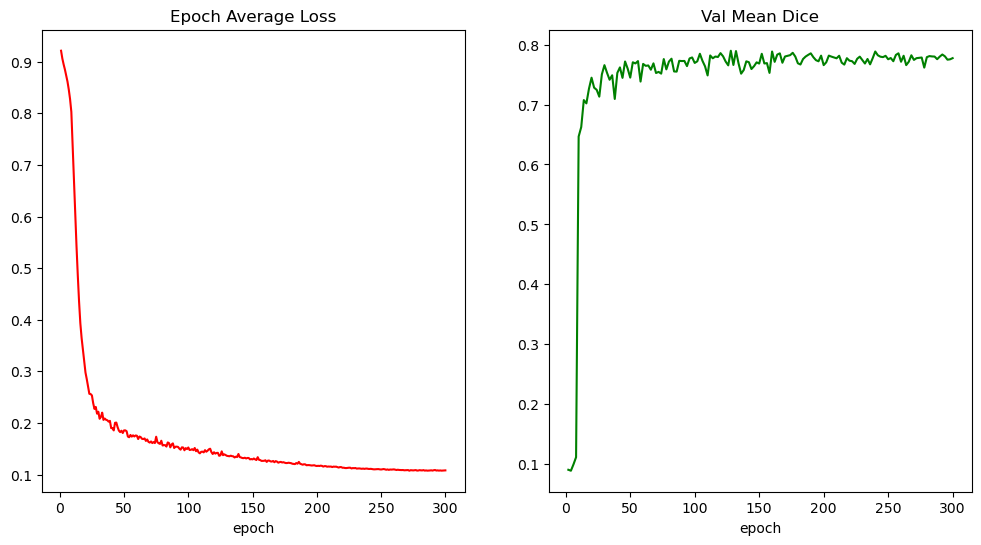

NameError: name 'metric_values_tc' is not defined

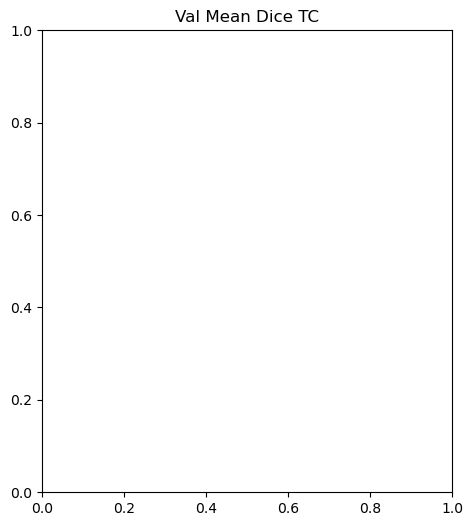

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

## Test

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


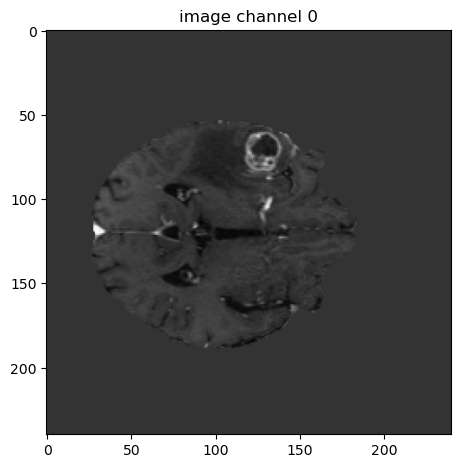

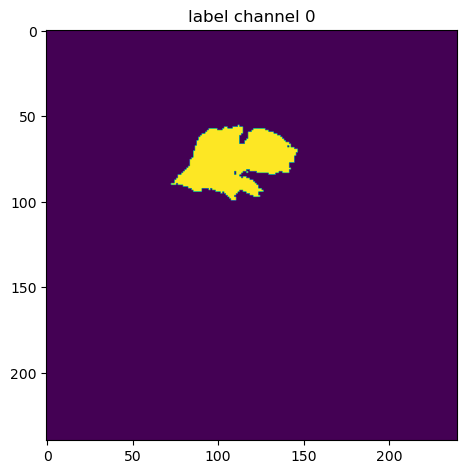

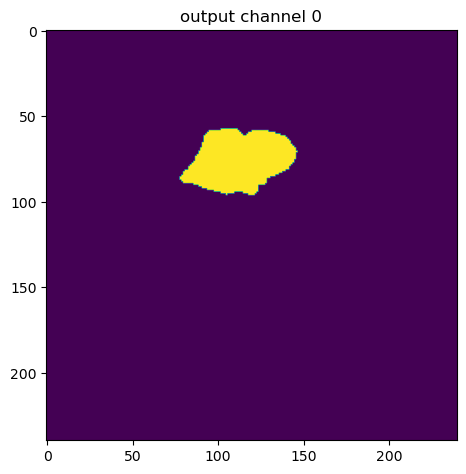

In [11]:
model.load_state_dict(torch.load(os.path.join('Checkpoints', "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(1):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(1):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(1):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()